In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import time
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import minmax_scale

plt.style.use('ggplot')
%matplotlib inline

In [34]:
ratings_df = pd.read_csv("rating.csv")
courses_df = pd.read_csv("course.csv")
users_df = pd.read_csv("user.csv")

In [12]:
users_df.head()

,UserID,Sex,Age,Job,Postcode
0,0,F,45,6,92103
1,1,M,50,16,55405-2546
2,2,M,18,20,44089
3,3,M,35,1,33304
4,4,M,35,6,48105


In [13]:
users_df.describe()

,UserID,Age,Job
count,6040.000000,6040.000000,6040.000000
mean,3020.465894,29.894868,8.200828
std,1743.799216,12.484335,10.933051
min,0.000000,1.000000,0.000000
25%,1510.750000,25.000000,1.000000
50%,3020.500000,25.000000,6.000000
75%,4530.250000,35.000000,13.000000
max,6040.000000,56.000000,98.000000


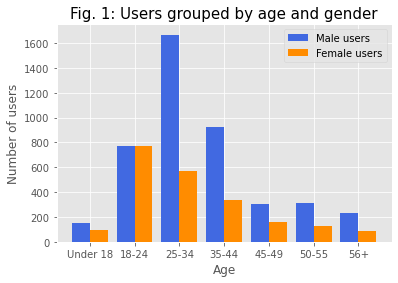

In [35]:
user_age_gender_data = users_df[['Sex', 'Age']]
female_user_ages = user_age_gender_data.loc[user_age_gender_data['Sex'] == 'F'].sort_values('Age')
male_user_ages = user_age_gender_data.loc[user_age_gender_data['Sex'] == 'M'].sort_values('Age')


def get_group_count(min_age, max_age, dataset):
    age_group = dataset.apply(lambda x: True if max_age > x['Age'] > min_age else False, axis=1)
    count = len(age_group[age_group == True].index)
    return count


G1_male = get_group_count(0, 18, male_user_ages)
G2_male = get_group_count(17, 25, male_user_ages)
G3_male = get_group_count(24, 35, male_user_ages)
G4_male = get_group_count(34, 45, male_user_ages)
G5_male = get_group_count(44, 50, male_user_ages)
G6_male = get_group_count(49, 56, male_user_ages)
G7_male = get_group_count(55, 200, male_user_ages)

G1_female = get_group_count(0, 18, female_user_ages)
G2_female = get_group_count(17, 25, female_user_ages)
G3_female = get_group_count(24, 35, female_user_ages)
G4_female = get_group_count(34, 45, female_user_ages)
G5_female = get_group_count(44, 50, female_user_ages)
G6_female = get_group_count(49, 56, female_user_ages)
G7_female = get_group_count(55, 200, female_user_ages)

labels = ['Under 18', '18-24', '25-34', '35-44', '45-49', '50-55', '56+']
men_grouped = [G1_male, G2_male, G3_male, G4_male, G5_male, G6_male, G7_male]
women_grouped = [G1_female, G2_male, G3_female, G4_female, G5_female, G6_female, G7_female]
x = np.arange(len(labels)) 
width = 0.40  

fig1, ax1 = plt.subplots()
rects1 = ax1.bar(x - width/2, men_grouped, width, label='Male users', color='royalblue')
rects2 = ax1.bar(x + width/2, women_grouped, width, label='Female users', color='darkorange')

ax1.set_ylabel('Number of users', size=12)
ax1.set_xlabel('Age', size=12)
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.set_title('Fig. 1: Users grouped by age and gender', size=15)
ax1.legend()

plt.show()

In [36]:
courses_df.head()

,CourseID,Tittle,Biology,Chemistry,Computer Science,Nursing,Geology,Electronics,Biotechnology,Physics,Microbiology,Agriculture,Horticulture,Nutrition and Dietetics,Zoology,Mathematics,Home Science,Forensic Science,Botany,Mechanical
0,0,course - 1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,1,course - 2,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2,2,course - 3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,3,course - 4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,course - 5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [37]:
courses_df.describe()

,CourseID,Biology,Chemistry,Computer Science,Nursing,Geology,Electronics,Biotechnology,Physics,Microbiology,Agriculture,Horticulture,Nutrition and Dietetics,Zoology,Mathematics,Home Science,Forensic Science,Botany,Mechanical
count,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000
mean,1973.687098,0.129539,0.072882,0.027041,0.040948,0.309039,0.054339,0.032707,0.412825,0.017512,0.011074,0.088334,0.029359,0.027041,0.121040,0.071079,0.126706,0.036827,0.017512
std,1142.105375,0.335839,0.259976,0.162224,0.198195,0.462157,0.226715,0.177891,0.492405,0.131187,0.104662,0.283816,0.168832,0.162224,0.326216,0.256990,0.332686,0.188362,0.131187
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,985.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1973.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2963.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3952.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [38]:
ratings_df.head()

,UserID,CourseID,Rating,Timestamp
0,0,1561,4,959441640
1,0,1540,3,959441640
2,0,88,3,959441640
3,0,620,4,959441640
4,0,3771,5,959442113


In [39]:
ratings_df.describe()

,UserID,CourseID,Rating,Timestamp
count,900117.000000,900117.000000,900117.000000,9.001170e+05
mean,2991.868675,1989.666242,3.581491,9.722407e+08
std,1736.208380,1126.359558,1.117162,1.214212e+07
min,0.000000,0.000000,1.000000,9.567039e+08
25%,1458.000000,1037.000000,3.000000,9.653030e+08
50%,2967.000000,1959.000000,4.000000,9.730170e+08
75%,4501.000000,2963.000000,4.000000,9.752206e+08
max,6040.000000,3952.000000,5.000000,1.046455e+09


In [40]:
domains = list(courses_df)[2:]
merged = pd.merge(ratings_df, courses_df, on='CourseID')

cleaned = merged[['CourseID', 'UserID', 'Rating', 'Biology', 'Chemistry', 'Computer Science', "Nursing", 'Geology',
                  'Electronics', 'Biotechnology', 'Physics', 'Microbiology', 'Agriculture', 'Horticulture',
                  'Nutrition and Dietetics', 'Zoology', 'Mathematics', 'Home Science', 'Forensic Science',
                  'Botany', 'Mechanical', 'Tittle']]

course_ratings = cleaned.sort_values('CourseID')
rating_scale = [1, 2, 3, 4, 5]

domains_rating_count = []
for domain in domains:
    for rating in rating_scale:
        domain_list = course_ratings.loc[course_ratings[domain] == 1]
        domain_rated_count = len(domain_list.loc[domain_list['Rating'] == rating])
        domains_rating_count.append([domain, rating, domain_rated_count])


def get_rating_count(score):
    rating_count = []
    for count in domains_rating_count:
        if count[1] == score:
            rating_count.append(count[2])

    return rating_count


def get_total_rating_count():
    all_ratings = []
    totals = []
    for count in domains_rating_count:
        all_ratings.append(count[2])

    lower = 0
    for i in range(lower, len(all_ratings), 5):
        lower = i
        totals.append(sum(all_ratings[lower:lower+5]))

    return totals


domain_df = pd.DataFrame({'Domain': [domain for domain in domains], 'Rated 1': get_rating_count(1),
              'Rated 2': get_rating_count(2), 'Rated 3': get_rating_count(3), 'Rated 4': get_rating_count(4),
              'Rated 5': get_rating_count(5), 'Total number of ratings': get_total_rating_count()})
domain_df["Average rating"] = (domain_df["Rated 1"] + (domain_df["Rated 2"] * 2) + (domain_df["Rated 3"] * 3) + 
                             (domain_df["Rated 4"] * 4) + (domain_df["Rated 5"] * 5)) / domain_df['Total number of ratings']
domain_df

,Domain,Rated 1,Rated 2,Rated 3,Rated 4,Rated 5,Total number of ratings,Average rating
0,Biology,14884,28359,63691,77911,46969,231814,3.490574
1,Chemistry,7675,15038,34070,39809,24009,120601,3.476273
2,Computer Science,1886,3264,9871,14258,9719,38998,3.683625
3,Nursing,3500,4776,10932,11917,6554,37679,3.351628
4,Geology,19410,36985,87148,111126,66128,320797,3.522377
5,Electronics,2879,6726,17580,25579,18800,71564,3.708387
6,Biotechnology,246,425,1293,2723,2405,7092,3.932882
7,Physics,10917,26252,76415,118548,86967,319099,3.765894
8,Microbiology,2152,4269,9405,10513,6291,32630,3.445051
9,Agriculture,243,764,2877,6186,6358,16428,4.074507


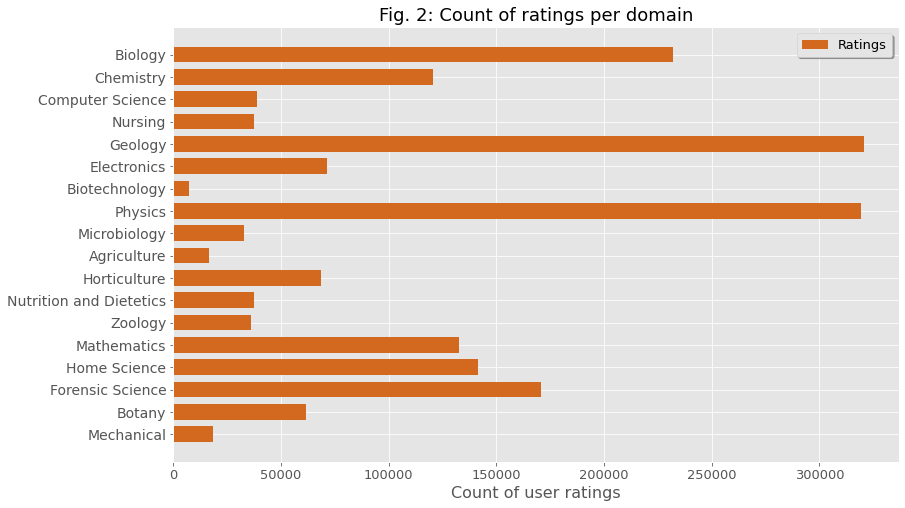

In [41]:
total_ratings = domain_df.iloc[:, 6].values.tolist()
fig2, ax2 = plt.subplots()
fig2_labels = [domain for domain in domains]
x = np.arange(len(fig2_labels))
width = 0.7
ax2.barh(x, total_ratings, width, label='Ratings', color='chocolate')

ax2.set_xlabel('Count of user ratings', size=16)
ax2.set_yticks(x)
ax2.set_yticklabels(fig2_labels, fontdict={'fontsize': 14})
ax2.set_title('Fig. 2: Count of ratings per domain', size=18)
ax2.invert_yaxis()
ax2.legend(shadow=0.4, prop={"size": 13})
plt.xticks(fontsize=13)

fig2.set_figheight(8)
fig2.set_figwidth(13)
plt.show()

<ipython-input-21-1f3c4d2b72be>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(fig3_xlabels, fontdict={'fontsize': 15})


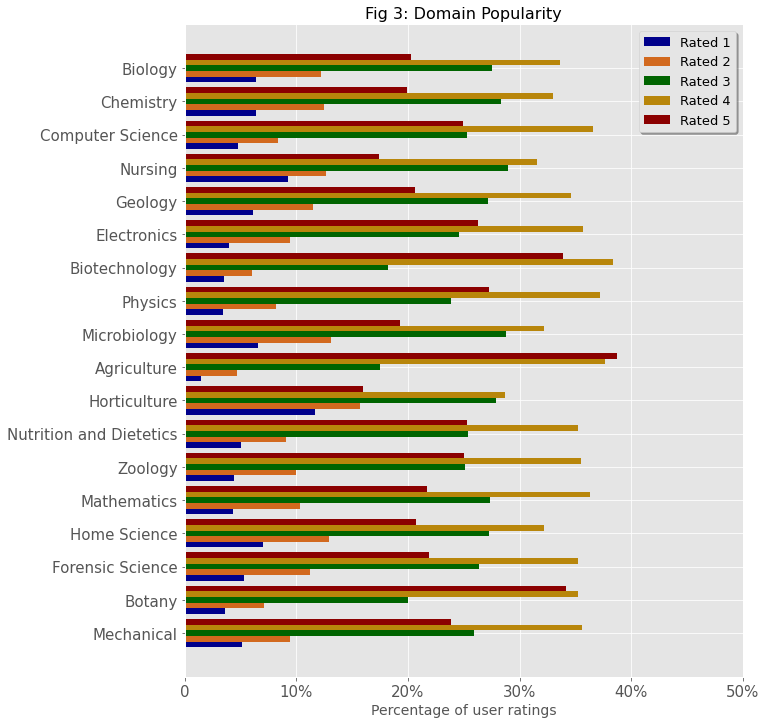

In [21]:
def get_rating_percentages(score):
    rated_count = domain_df.iloc[:, score].values.tolist()
    rating_percentages = []
    i = 0

    for total in total_ratings:
        percentage = (100 / total) * rated_count[i]
        i += 1
        rating_percentages.append(round(percentage, 1))

    return rating_percentages


domain_rating_percentage_data = {'Domain': [domain for domain in domains], 'Rated 1': get_rating_percentages(1),
                                'Rated 2': get_rating_percentages(2), 'Rated 3': get_rating_percentages(3),
                                'Rated 4': get_rating_percentages(4), 'Rated 5': get_rating_percentages(5),
                                'Total number of ratings': get_total_rating_count()}
domain_rating_percent_df = pd.DataFrame(domain_rating_percentage_data)

rated_1_percentage = domain_rating_percent_df.iloc[:, 1].values.tolist()
rated_2_percentage = domain_rating_percent_df.iloc[:, 2].values.tolist()
rated_3_percentage = domain_rating_percent_df.iloc[:, 3].values.tolist()
rated_4_percentage = domain_rating_percent_df.iloc[:, 4].values.tolist()
rated_5_percentage = domain_rating_percent_df.iloc[:, 5].values.tolist()

fig3, ax3 = plt.subplots()
fig3_ylabels = [domain for domain in domains]
fig3_xlabels = ['0', '10%', '20%', '30%', '40%', '50%']
x = np.arange(len(fig3_ylabels))
width = 0.17

ax3.barh(x + width*2, rated_1_percentage, width, label='Rated 1', color='darkblue')
ax3.barh(x + width, rated_2_percentage, width, label='Rated 2', color='chocolate')
ax3.barh(x, rated_3_percentage, width, label='Rated 3', color='darkgreen')
ax3.barh(x - width, rated_4_percentage, width, label='Rated 4', color='darkgoldenrod')
ax3.barh(x - width*2, rated_5_percentage, width, label='Rated 5', color='darkred')

ax3.set_xlabel('Percentage of user ratings', size=14)
ax3.set_xticklabels(fig3_xlabels, fontdict={'fontsize': 15})
ax3.set_xlim(right=50)
ax3.set_yticks(x)
ax3.set_yticklabels(fig3_ylabels, fontdict={'fontsize': 15})
ax3.set_title('Fig 3: Domain Popularity', size=16)
ax3.invert_yaxis()
ax3.legend(shadow=0.4, prop={"size": 13})

fig3.set_figheight(12)
fig3.set_figwidth(10)
plt.show()

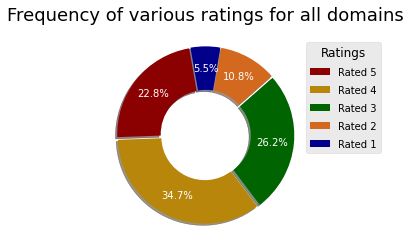

In [42]:
def get_rating_percentage_total(score):
    rated_count = domain_df.iloc[:, score].values.tolist()
    total_ratings_count = 0
    sum_ratings = 0

    for count in rated_count:
        sum_ratings += count

    for total in total_ratings:
        total_ratings_count += total

    return round((sum_ratings / total_ratings_count) * 100, 1)


ratings_data = [get_rating_percentage_total(5), get_rating_percentage_total(4), get_rating_percentage_total(3),
                get_rating_percentage_total(2), get_rating_percentage_total(1)]

labels = ["Rated 5", "Rated 4", "Rated 3", "Rated 2", "Rated 1"]
fig4, ax4 = plt.subplots(subplot_kw=dict(aspect="equal"))
wedges, texts, autotext = ax4.pie(ratings_data, autopct='%1.1f%%', pctdistance=0.75, shadow=True,
                                  wedgeprops=dict(width=0.5), startangle=100, textprops=dict(color="w"),
                                  explode=(0.02, 0.02, 0.02, 0.02, 0.02), colors=['darkred', 'darkgoldenrod',
                                                                                  'darkgreen', 'chocolate', 'darkblue'])

ax4.legend(wedges, labels, loc="upper right", bbox_to_anchor=(1.0, 0.05, 0.33, 0.9), title='Ratings',
           title_fontsize='12', labelspacing=0.8)
ax4.set_title("Frequency of various ratings for all domains", size=18)

plt.show()

          Rating
UserID          
0       3.296610
1       3.487179
2       3.600000
3       4.000000
4       3.891892


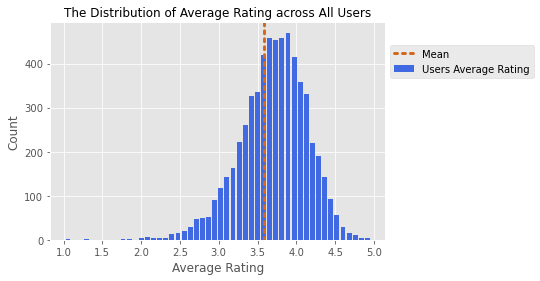

In [43]:
users_avg_rating = pd.DataFrame(ratings_df.groupby('UserID')['Rating'].mean())
print(users_avg_rating.head())

users_avg_rating = users_avg_rating['Rating']
fig5, ax5 = plt.subplots()
n, bins, patches = ax5.hist(users_avg_rating, label='Users Average Rating',
                            stacked=True, color='royalblue', bins=50, rwidth=0.8)

ax5.set_xlabel('Average Rating', size=12)
ax5.set_ylabel('Count', size=12)
ax5.set_title('The Distribution of Average Rating across All Users', size=12)

plt.axvline(ratings_df["Rating"].mean(), color='chocolate', linestyle='dotted', dash_capstyle="round",
            linewidth=3, label="Mean")
ax5.legend(bbox_to_anchor=(1, 0.92))

plt.show()

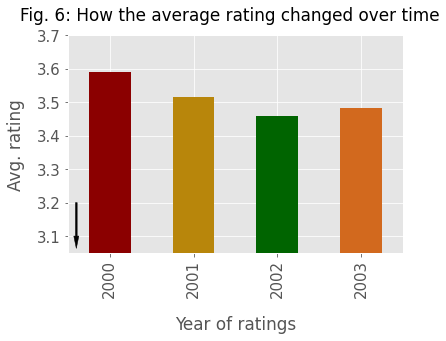

In [44]:
def convert_timestamp_to_year(timestamp):
    date_string = time.ctime(timestamp)
    tokens = date_string.split(sep=" ")
    year = int(tokens[-1])
    return year


ratings_copy = ratings_df.copy()
ratings_copy['Ranking year'] = ratings_df["Timestamp"].map(lambda timestamp: convert_timestamp_to_year(timestamp))
yearly_mean_rating = ratings_copy.groupby('Ranking year')['Rating'].mean()

plt.figure()
plt.rcParams.update({'font.size': 14})
yearly_mean_rating.plot(kind='bar', figsize=(10, 10), title="Fig. 6: How the average rating changed over time",
                        subplots=True, color=['darkred', 'darkgoldenrod', 'darkgreen', 'chocolate'],
                        ylim=(3.05, 3.7), fontsize=15, label='')
plt.xlabel(xlabel='Year of ratings', labelpad=18)
plt.ylabel(ylabel='Avg. rating', labelpad=12)

plt.arrow(x=(-0.4), y=3.2, dx=0, dy=(-0.1), width=0.02, length_includes_head=False, head_length=0.037, head_width=0.06,
          color='black')

plt.show()

In [45]:
X = ratings_df.drop(columns='Rating')
y = ratings_df["Rating"].values

X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X, y, test_size=0.3, random_state=101)
X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=0.5, random_state=101)

train_df = X_train.copy()
train_df["Rating"] = y_train

train_df

,UserID,CourseID,Timestamp,Rating
708938,4341,1210,976573899,3
371257,1425,3192,970774826,4
845603,5565,2299,976239652,5
667558,3970,83,965770467,3
821518,5320,3843,976249576,4
...,...,...,...,...
661055,3915,1846,974698675,4
204614,32,884,974679433,4
476497,2357,101,975126955,4
214539,122,2098,974662091,4


In [46]:
baseline_y_pred = pd.DataFrame(train_df.groupby('CourseID')['Rating'].mean())

val_courses_dict = {'CourseID': X_val["CourseID"], 'Actual rating': y_val}  
val_courses_df = pd.DataFrame(val_courses_dict)

y_pred_and_y_true = pd.merge(baseline_y_pred, val_courses_df, on='CourseID')
baseline_y_pred_vs_y_true = y_pred_and_y_true.rename(columns={"Rating": "Predicted rating"})

baseline_y_pred_vs_y_true

,CourseID,Predicted rating,Actual rating
0,0,2.055556,1
1,0,2.055556,4
2,0,2.055556,3
3,0,2.055556,2
4,0,2.055556,2
...,...,...,...
134982,3952,2.353846,2
134983,3952,2.353846,1
134984,3952,2.353846,1
134985,3952,2.353846,3


In [47]:
print("RMSE baseline model: ", sqrt(mean_squared_error(baseline_y_pred_vs_y_true["Predicted rating"], 
                                                       baseline_y_pred_vs_y_true["Actual rating"])))

RMSE baseline model:  0.981626106076701


In [48]:
content_train_df = pd.merge(train_df, courses_df, on='CourseID')
content_train_df.drop(columns=['Timestamp', 'CourseID', 'Tittle'], inplace=True)

content_train_df

,UserID,Rating,Biology,Chemistry,Computer Science,Nursing,Geology,Electronics,Biotechnology,Physics,Microbiology,Agriculture,Horticulture,Nutrition and Dietetics,Zoology,Mathematics,Home Science,Forensic Science,Botany,Mechanical
0,4341,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1242,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,1056,5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,4381,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,1134,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630076,4551,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
630077,455,4,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
630078,2305,4,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
630079,317,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [49]:
y_grouped_by_user = content_train_df.groupby(["UserID"])
y_train_listed = []

for i, j in y_grouped_by_user:
    y_train_listed.append(j["Rating"].values)
    
y_train_listed[0]

array([4, 1, 4, 3, 5, 3, 4, 3, 5, 2, 4, 4, 4, 3, 4, 5, 2, 2, 5, 4, 3, 2,
       4, 4, 3, 2, 3, 3, 5, 4, 5, 1, 5, 3, 3, 2, 4, 3, 3, 4, 5, 3, 2, 4,
       3, 5, 1, 1, 4, 4, 3, 2, 1, 4, 4, 3, 3, 3, 4, 4, 3, 3, 1, 4, 4, 5,
       4, 3, 3, 4, 2, 3, 2, 2, 4, 4, 3, 5, 4, 2, 4, 3, 3, 3, 4, 2, 4, 5,
       4, 3, 3, 4, 3, 2, 3, 2, 3, 4, 3, 4, 4, 4, 5, 3, 3, 4, 3, 3, 4, 3,
       3, 3, 3, 3, 3, 3, 4, 4, 3, 4, 4, 4, 3, 4, 3, 3, 5, 3, 4, 2, 3, 3,
       3, 3, 5, 2, 4, 3, 3, 4, 4, 3, 3, 5, 3, 2, 1, 3, 3, 3, 2, 3, 4, 3,
       2, 3, 3, 3, 4, 3, 4, 4, 2, 3, 3, 3, 2, 3, 4, 3], dtype=int64)

In [50]:
content_train_df.drop(columns='Rating', inplace=True)
x_grouped_by_user = content_train_df.groupby(["UserID"])
x_train_listed = []

for user_id, group in x_grouped_by_user:
    x_train_listed.append(group.drop(columns='UserID'))
    
x_train_listed[0]

,Biology,Chemistry,Computer Science,Nursing,Geology,Electronics,Biotechnology,Physics,Microbiology,Agriculture,Horticulture,Nutrition and Dietetics,Zoology,Mathematics,Home Science,Forensic Science,Botany,Mechanical
2824,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
9073,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
14756,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
18316,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
22117,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618870,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
618897,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
619528,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0
625089,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


In [51]:
all_courses = courses_df.drop(columns=['Tittle', 'CourseID'])
all_courses

,Biology,Chemistry,Computer Science,Nursing,Geology,Electronics,Biotechnology,Physics,Microbiology,Agriculture,Horticulture,Nutrition and Dietetics,Zoology,Mathematics,Home Science,Forensic Science,Botany,Mechanical
0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3879,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3880,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
3881,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


In [52]:
user_ids = []
for user_id, group in x_grouped_by_user:
    user_ids.append(user_id)
    
course_ids = courses_df["CourseID"].values

df_val = X_val.copy()
df_val["Rating"] = y_val
validation_matrix = pd.DataFrame(index=user_ids, columns=course_ids)
for array in df_val.to_records():
    user = array['UserID']
    course = array['CourseID']
    true_rating = array['Rating']
    validation_matrix.loc[user][course] = true_rating
    
validation_matrix

,0,1,2,3,4,5,6,7,8,9,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
ml_algorithms = {"Linear regression": LinearRegression(), "Lasso": Lasso(alpha=1.0, max_iter=10000), 
                 "KNN_7": KNeighborsRegressor(n_neighbors=7),
                 "RFR": RandomForestRegressor(n_estimators=1000, n_jobs=3, max_features=5, random_state=0),
                 "SVR": SVR(C=1.0)}

CBF_models_listed = []
RMSE_CBF_listed = []

for name, ml_alg in ml_algorithms.items():
    CBF_predictions = []

    for i, x in enumerate(x_train_listed):
        ml_alg.fit(x_train_listed[i], y_train_listed[i])
        prediction = ml_alg.predict(all_courses)
        prediction = np.clip(prediction, 1, 5)
        CBF_predictions.append(prediction)

    df_predict = pd.DataFrame(CBF_predictions, index=user_ids, columns=course_ids)

    num_actual = validation_matrix.to_numpy().flatten()[validation_matrix.notna().to_numpy().flatten()]
    num_predict = df_predict.to_numpy().flatten()[validation_matrix.notna().to_numpy().flatten()]

    RMSE_CBF_listed.append(sqrt(mean_squared_error(num_predict, num_actual)))
    CBF_models_listed.append(name)

RMSE_CBF_df = pd.DataFrame({"Model": CBF_models_listed, "RMSE": RMSE_CBF_listed})
print("RMSE of different content-based filtering models:")
RMSE_CBF_df

C:\Users\gmbha\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


In [28]:
model = Lasso(alpha=1.0, max_iter=10000)
CBF_predictions = []

for i, j in enumerate(x_train_listed):
    model.fit(x_train_listed[i], y_train_listed[i])
    prediction = model.predict(all_courses)
    prediction = np.clip(prediction, 1, 5)
    CBF_predictions.append(prediction)

CBF_model = pd.DataFrame(CBF_predictions, index=user_ids, columns=course_ids)

In [46]:
train_df.head()

,UserID,CourseID,Timestamp,Rating
708938,4341,1210,976573899,3
371257,1425,3192,970774826,4
845603,5565,2299,976239652,5
667558,3970,83,965770467,3
821518,5320,3843,976249576,4


In [24]:
user_matrix = train_df.pivot(index='UserID', columns='CourseID', values='Rating')

user_matrix = user_matrix.sub(user_matrix.mean(axis=1), axis=0)

user_matrix = user_matrix.fillna(0.0)

In [25]:
user_dist_matrix = 1 - user_matrix.T.corr()
user_dist_matrix

UserID,0,1,2,3,4,5,6,7,8,9,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
UserID,,,,,,,,,,,,,,,,,,,,,
0,0.000000,1.008851,1.000000,0.870659,1.004774,1.005061,0.985787,0.993054,0.936473,1.000721,...,1.000000,0.993009,0.919575,1.008068,1.000520,1.004525,0.987334,1.019618,1.108225,0.992078
1,1.008851,0.000000,1.000000,1.000000,1.038525,1.215623,1.013271,0.981892,0.966971,0.972867,...,1.000000,1.014202,0.986063,0.993568,1.000000,1.000000,1.008252,1.011828,0.992498,1.027741
2,1.000000,1.000000,0.000000,1.000000,0.954233,1.000000,1.002765,0.967496,1.024260,0.956310,...,1.000000,0.939836,0.949094,0.938041,0.968789,0.914610,1.084354,1.000000,0.989900,1.029691
3,0.870659,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.911999,1.033222,...,1.000000,1.096116,1.000000,0.998262,1.000000,1.000000,1.001476,1.000000,1.000000,1.071963
4,1.004774,1.038525,0.954233,1.000000,0.000000,0.966535,1.079381,0.970525,0.924106,0.932877,...,0.994337,0.952138,0.979018,1.007612,1.046063,1.020158,0.936568,1.076701,1.008673,1.018350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,1.004525,1.000000,0.914610,1.000000,1.020158,1.000000,1.001341,0.931767,0.978402,0.988251,...,0.948502,0.975727,0.992479,0.984205,0.964859,0.000000,1.067465,1.000000,0.941595,1.008256
6037,0.987334,1.008252,1.084354,1.001476,0.936568,1.000000,1.003874,1.016693,0.986043,1.021241,...,1.000000,0.928262,1.027527,0.927628,1.105656,1.067465,0.000000,1.028313,1.000000,0.969143
6038,1.019618,1.011828,1.000000,1.000000,1.076701,1.000000,0.978866,1.000000,1.028991,0.961786,...,1.000000,0.981633,1.010349,0.987804,1.002550,1.000000,1.028313,0.000000,1.000000,0.998009


In [3]:
ml_algorithms = {'kNN-5': 5, 'kNN-10': 10, 'kNN-20': 20, 'kNN-30': 30, 'kNN-40': 40, "kNN-60": 60}

models_CF = []
RMSE_CF = []

for name, num_neighbours in ml_algorithms.items():
    predictions = []

    for index, row in X_val.iterrows():
        if row["CourseID"] in X_train["CourseID"].unique():
            users_rated_course = X_train.loc[X_train['CourseID'] == row['CourseID'], 'UserID']
            users_sorted = (user_dist_matrix.loc[row['UserID'], users_rated_course].sort_values())
            nearest_neighbours = users_sorted[:num_neighbours]
            nn_data = train_df.loc[train_df['UserID'].isin(nearest_neighbours.index.to_list())]
            nearest_neighbours_avg_rating = np.average(nn_data.loc[train_df['CourseID'] == row['CourseID'], 'Rating'],
                                                       axis=0, weights=(1/nearest_neighbours))
        else:
            nearest_neighbours_avg_rating = 4

        if not np.isnan(nearest_neighbours_avg_rating):
            predictions.append(nearest_neighbours_avg_rating)
        else:
            predictions.append(3)

    models_CF.append(name)
    RMSE_CF.append(sqrt(mean_squared_error(y_val, predictions)))

RMSE_CF_dict = {"Model": models_CF, "RMSE": RMSE_CF}
RMSE_CF_df = pd.DataFrame(RMSE_CF_dict)
RMSE_CF_df

,Model,RMSE
0,kNN-5,1.013958
1,kNN-10,0.978301
2,kNN-20,0.962699
3,kNN-30,0.959578
4,kNN-40,0.958769
5,kNN-60,0.959030


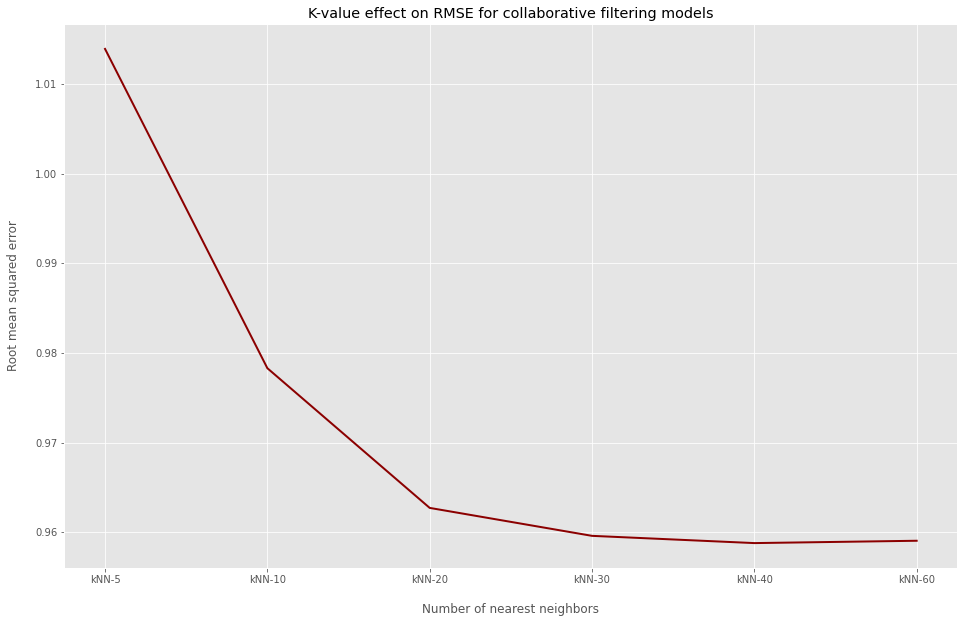

In [8]:
fig7, ax7 = plt.subplots()
ax7.plot(RMSE_CF_df.Model, RMSE_CF_df.RMSE, label="RMSE", color='darkred', linewidth=2)
plt.xlabel("Number of nearest neighbors", labelpad=18)
plt.ylabel("Root mean squared error", labelpad=15)
plt.title("K-value effect on RMSE for collaborative filtering models")
fig7.set_figheight(10)
fig7.set_figwidth(16)
plt.show()

In [27]:
best_CF_model = []
RMSE_best_CF = []

CF_predictions = []

for index, row in X_val.iterrows():
    if row["CourseID"] in X_train["CourseID"].unique():
        users_rated_course = X_train.loc[X_train['CourseID'] == row['CourseID'], 'UserID']
        users_sorted = (user_dist_matrix.loc[row['UserID'], users_rated_course].sort_values())
        nearest_neighbours = users_sorted[:40]
        nn_data = train_df.loc[train_df['UserID'].isin(nearest_neighbours.index.to_list())]
        nearest_neighbours_avg_rating = np.average(nn_data.loc[train_df['CourseID'] == row['CourseID'], 'Rating'],
                                                   axis=0, weights=(1/nearest_neighbours))
    else:
        nearest_neighbours_avg_rating = 4

    if not np.isnan(nearest_neighbours_avg_rating):
        CF_predictions.append(nearest_neighbours_avg_rating)
    else:
        CF_predictions.append(4)

In [26]:
CBF_predictions = []
for index, row in X_val.iterrows():
    user_predictions = CBF_model.loc[row["UserID"], row["CourseID"]]
    CBF_predictions.append(user_predictions)
    
print("RMSE combined approach (Lasso and KNN-40):")
weighted_avgs = [(0.5, 0.5), (0.45, 0.55), (0.4, 0.6), (0.35, 0.65), (0.3, 0.7), (0.25, 0.75), (0.20, 0.80)]
  
for weight in weighted_avgs:
    combined_predictions = np.array([y_pred * weight[0] for y_pred in np.array(CBF_predictions)]) + np.array([y_pred * weight[1] for y_pred in np.array(CF_predictions)])
    print(f"RMSE for combined approach with CBF weighted {weight[0]} and CF weighted {weight[1]}: \n",
          sqrt(mean_squared_error(y_val, combined_predictions)), "\n")

RMSE combined approach (Lasso and KNN-40):
RMSE for combined approach with CBF weighted 0.5 and CF weighted 0.5: 
 0.9383490270968214

RMSE for combined approach with CBF weighted 0.45 and CF weighted 0.55: 
 0.9347989553339932

RMSE for combined approach with CBF weighted 0.4 and CF weighted 0.6: 
 0.9324893533664824

RMSE for combined approach with CBF weighted 0.35 and CF weighted 0.65: 
 0.9314294489645997

RMSE for combined approach with CBF weighted 0.3 and CF weighted 0.7: 
 0.9316235074661314

RMSE for combined approach with CBF weighted 0.25 and CF weighted 0.75: 
 0.9330707464800498

RMSE for combined approach with CBF weighted 0.2 and CF weighted 0.8: 
 0.9357653515804694

